Begun 2/4/2025

In pixell_sim_bincount_test_05_20250204.ipynb, we found that w2w4 is undershooting the total power in simulations. To disentangle any mask effects from full sky vs cut sky effects, I am going to redo the analysis of that notebook in healpix, but still using the real ivar and mask for depth-1 maps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Loading in CAMB input spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
keys_eshow = {"downgrade": 4, "ticks": 5, "colorbar": True, "font_size": 40}

def eshow(x,**kwargs): 
    ''' Function to plot the maps for debugging '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "auto")

# Needed functions from axion_osc_analysis_depth1_ps.py
def make_tapered_mask(map_to_mask,filter_radius=0.5,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.

        The default radius is 0.5 deg - we apply this twice though when using ivar
        weighting since we throw away the first taper post-filtering and make a new
        one post-ivar weighting, so the total radius is still around 1.0 deg as it
        originally was when tapering once.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering used for 
    # calculating ivar_sum in the non-tapered region and removing taper for second mask
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def taper_mask_first_time(depth1_ivar, galaxy_mask, shape, wcs, filter_radius):
    """Moving generating the first mask for filtering to another function to reduce memory overhead"""
    galaxy_mask_cut = enmap.extract(galaxy_mask,shape,wcs)
    depth1_filtering_mask, depth1_indices = make_tapered_mask(depth1_ivar*galaxy_mask_cut,filter_radius=filter_radius)
    return depth1_filtering_mask, depth1_indices

def taper_mask_second_time(first_mask, first_indices, filter_radius):
    """Moving the second tapering of mask to make mask for ivar weighting to another function to reduce memory overhead"""
    first_mask_copy = first_mask.copy()      # ensuring no weirdness happens to first mask
    first_mask_copy[first_indices] = 0.0     # setting pixels in taper and outside to zero
    second_mask_tapered, second_indices = make_tapered_mask(first_mask_copy,filter_radius=filter_radius)
    return second_mask_tapered, second_indices

def normalize_ivar_mask(input_ivar, mask_indices):
    """Putting the normalization of the ivar mask into a function to reduce memory footprint"""
    ivar_inside_taper = input_ivar.copy() # to ensure no weirdness happens to original ivar
    ivar_inside_taper[mask_indices] = 0.0 # Setting all tapered points and beyond to zero so normalization doesn't happen to a tapered point

    # There are a small number of isolated outlier pixels in the ivar map. To prevent them from
    # having a outsized effect on the normalization, we normalize to the 95th percentile of the map.
    # Anything in the 95th-100th percentile is set to 1.0
    # For very small maps, sometimes numpy rounds np.percentile to 0.0 - catch these and normalize by np.max() in those cases
    if np.percentile(2.0*ivar_inside_taper, 95)!=0.0:
        norm_ivar_T_mask = 2.0*ivar_inside_taper / np.percentile(2.0*ivar_inside_taper, 95) # Weighting by the original temperature ivar for T
        norm_ivar_T_mask[norm_ivar_T_mask > 1.0] = 1.0 # Setting any outliers to 1.0
    else:
        norm_ivar_T_mask = 2.0*ivar_inside_taper / np.max(2.0*ivar_inside_taper)
    if np.percentile(ivar_inside_taper, 95)!=0.0:
        norm_ivar_QU_mask = ivar_inside_taper / np.percentile(ivar_inside_taper, 95)
        norm_ivar_QU_mask[norm_ivar_QU_mask > 1.0] = 1.0 # Setting any outliers to 1.0
    else:
        norm_ivar_QU_mask = ivar_inside_taper / np.max(ivar_inside_taper)

    # Now that things are normalized in the region we will take the PS on, set the region
    # outside of it to 1.0 so that it gets tapered and masked appropriately by the PS mask
    norm_ivar_T_mask[mask_indices] = 1.0
    norm_ivar_QU_mask[mask_indices] = 1.0
    
    return norm_ivar_T_mask, norm_ivar_QU_mask

def apply_ivar_weighting(input_kspace_TEB_maps, input_ivar, ivar_mask, mask_indices):
    """For a set of TEB Fourier space maps, converts back to real space, multiplies by
       the normalized inverse variance map and the tapered mask, and converts back to Fourier space
       for PS calculation.
       The normalized inverse variance map is only calculated inside the tapered region so that the
       structure of the ivar map doesn't make the taper non-smooth and so that we are ivar weighting
       only in the region where the PS will be calculated.   
    """
    # Will just call this once per map on its own
    #norm_ivar_T_mask, norm_ivar_QU_mask = normalize_ivar_mask(input_ivar, mask_indices)

    # Converting Fourier space maps to realspace, then multiplying by normalized ivar
    # mask and tapered PS mask
    maps_realspace = enmap.harm2map(input_kspace_TEB_maps, normalize = "phys")
    maps_ivar_weight = enmap.zeros((3,) + maps_realspace[0].shape, wcs=maps_realspace[0].wcs)
    maps_ivar_weight[0] = maps_realspace[0]*norm_ivar_T_mask*ivar_mask 
    maps_ivar_weight[1] = maps_realspace[1]*norm_ivar_QU_mask*ivar_mask
    maps_ivar_weight[2] = maps_realspace[2]*norm_ivar_QU_mask*ivar_mask
    #eshow(maps_realspace[1]*norm_ivar_QU_mask*ivar_mask, **keys_eshow)
    # Converting back to harmonic space - already multiplied by tapered Ivar_mask above
    output_kspace_TEB_maps = enmap.map2harm(maps_ivar_weight, normalize = "phys")
    return output_kspace_TEB_maps, norm_ivar_QU_mask*ivar_mask

def spectrum_from_maps(map1, map2, b_ell_bin_1, b_ell_bin_2, w2, bins):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))

    modlmap = map1.modlmap()

    # Bin the power spectrum
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    # Dividing by an approx. correction for the loss of power from tapering
    binned /= w2
    # Dividing by correction for the beam of each map
    binned /= (b_ell_bin_1*b_ell_bin_2)

    return binned, bincount

def get_hivon_fsky_enmap(mask):
    imap = mask/np.max(mask)
    w2w4 = (np.mean(imap**2.)**2./np.mean(imap**4.))
    skyarea = imap.area()/(4.*np.pi) # no w factor so I can easily try both
    return skyarea

In [4]:
# Grabbing our new list with more maps to choose from
# Will choose from the maps that passed cuts in array_diff_larger_set_w2w4_higherell_largerbins_20250203.ipynb
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_w_second_batch_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

Map name: depth1_1494761700_pa5_f150_map.fits
Maps shape:  (2710, 6093)  Maps WCS:  car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[9018.00,6252.00]}


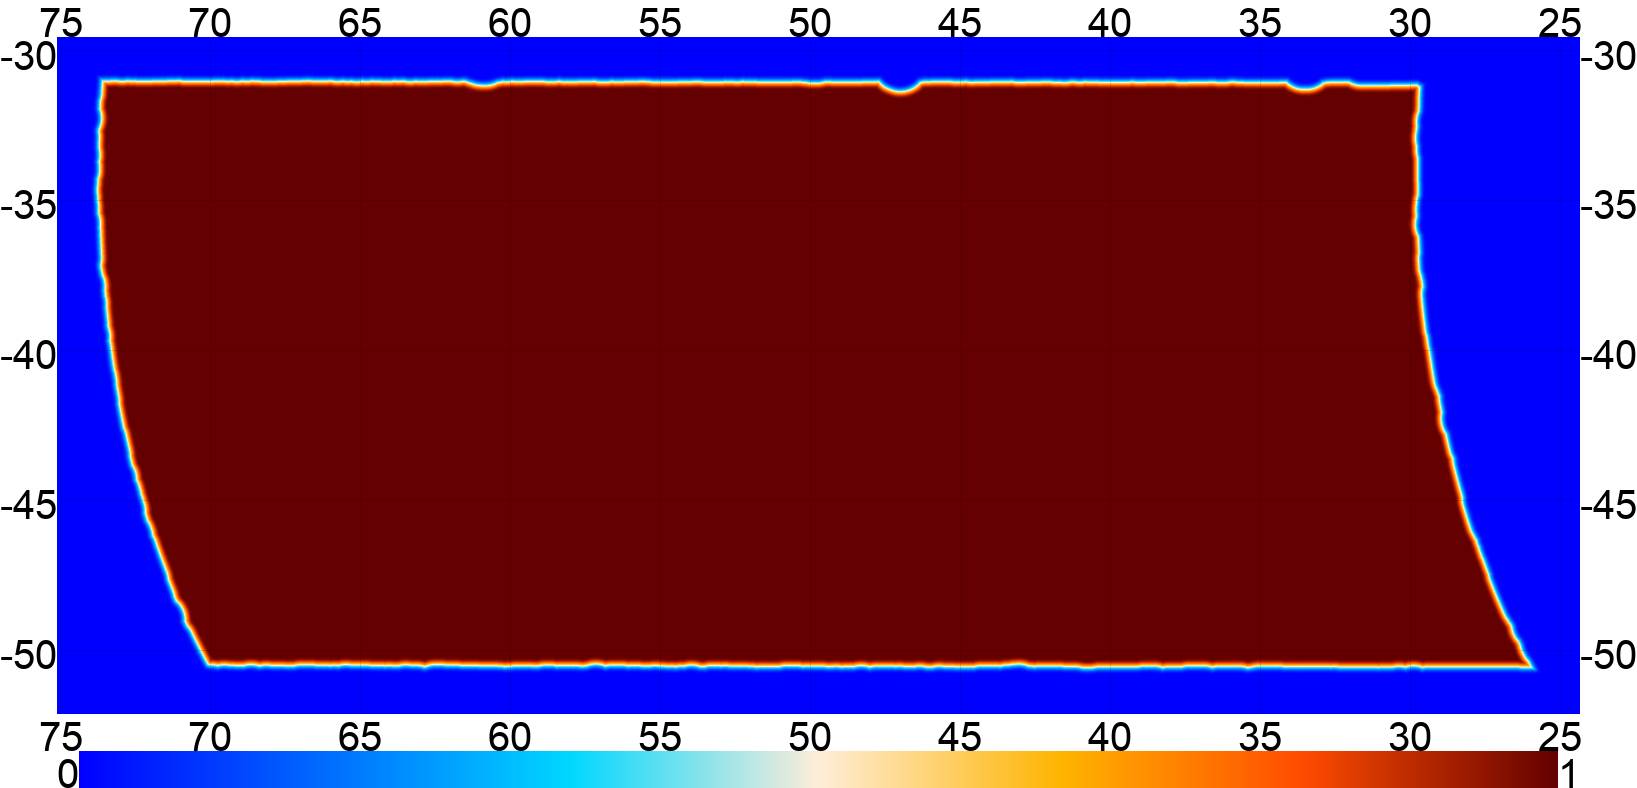

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [51:30<00:00, 61.81s/it]


Map name: depth1_1494761700_pa5_f150_map.fits
w2:  0.011517539585057126
w2w4:  0.014803284851551884
w2/w2w4:  0.7780394487139588
f_sky w/no w factor: 0.020904207140256082


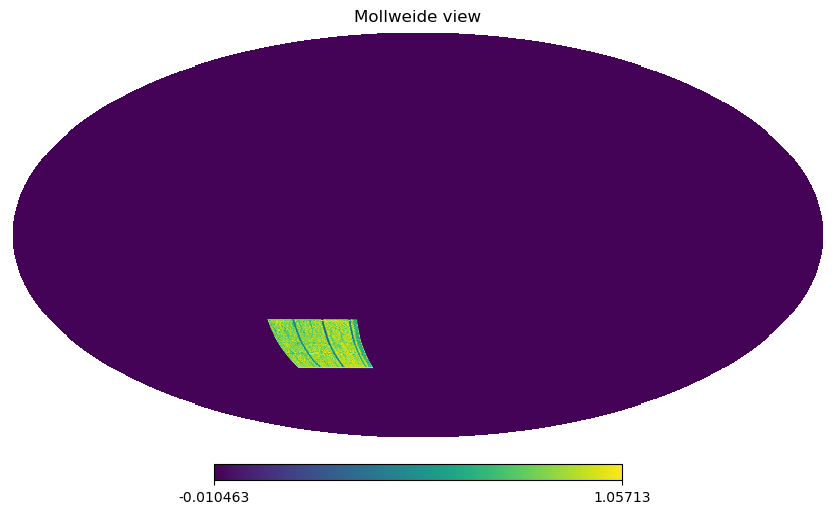

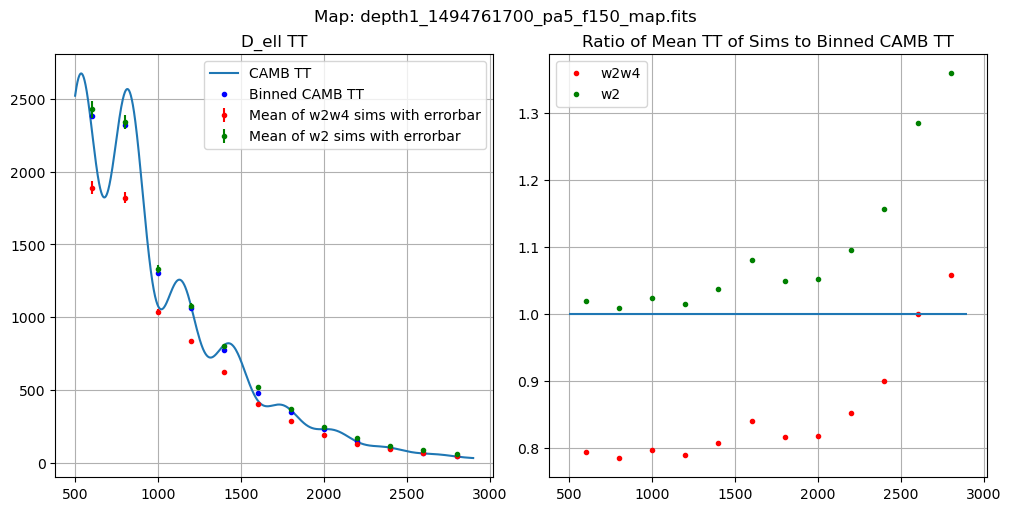

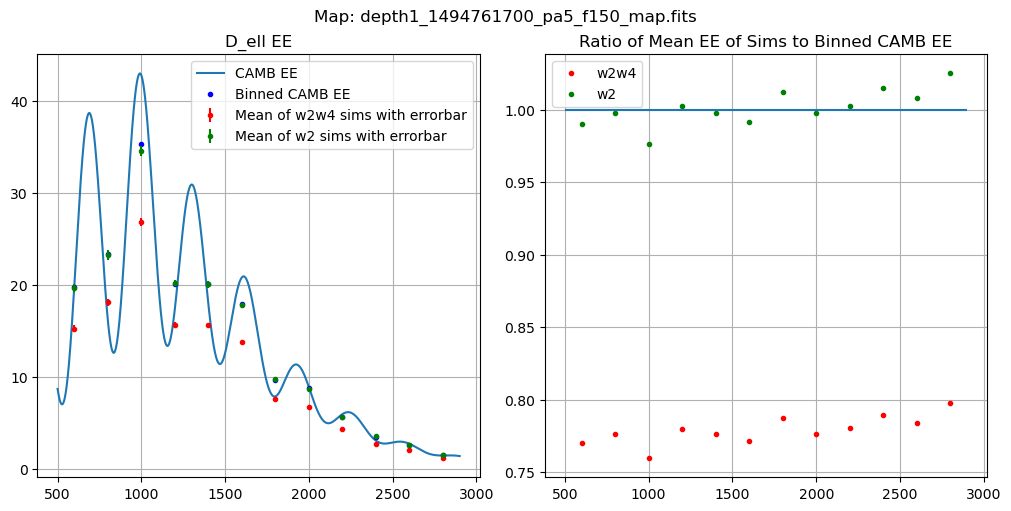

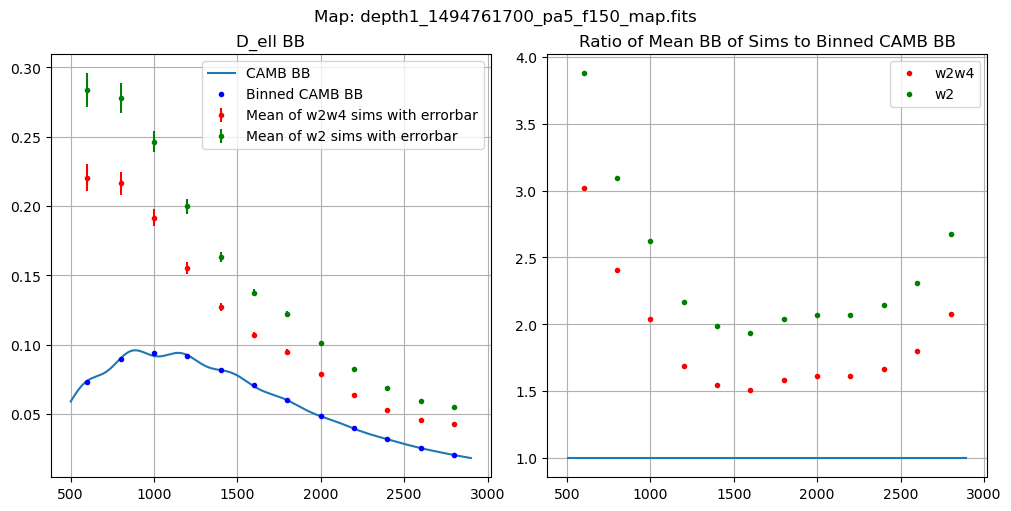

Map name: depth1_1514459190_pa5_f150_map.fits
Maps shape:  (2151, 5630)  Maps WCS:  car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[-12135.00,-332.00]}


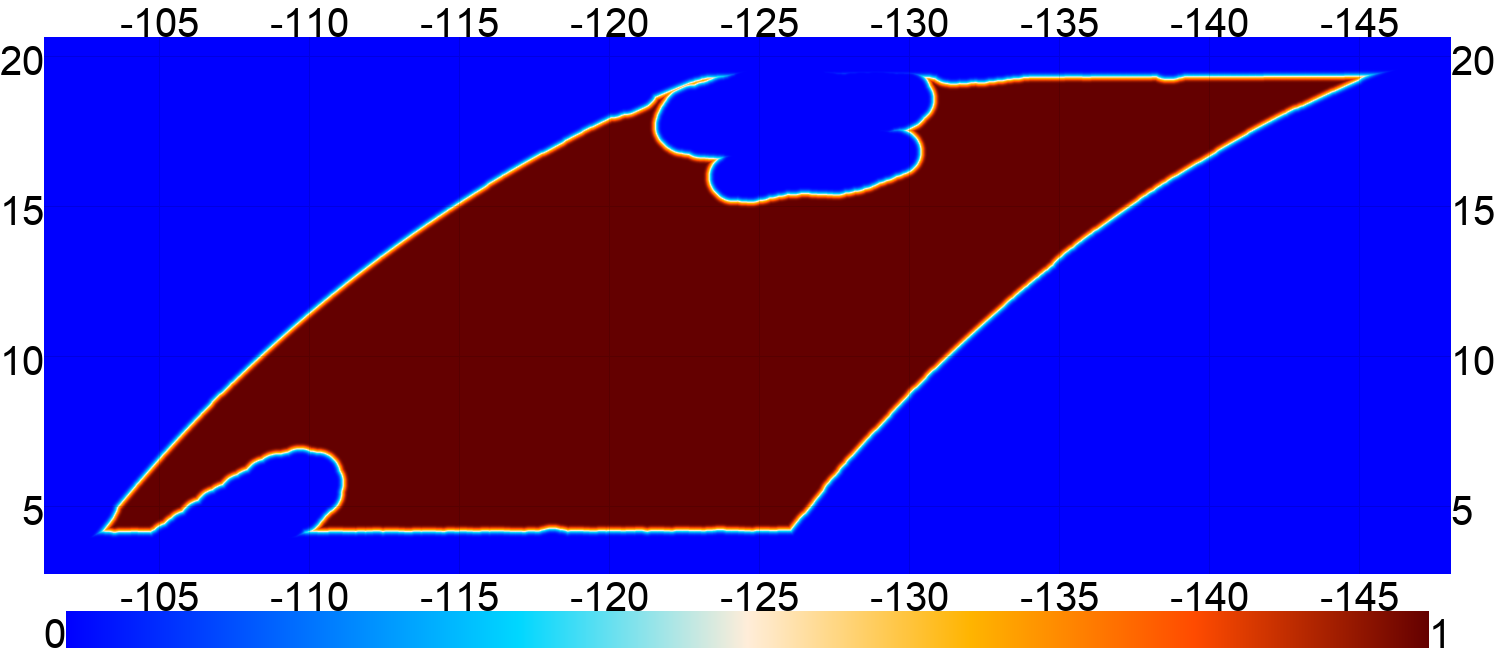

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [51:30<00:00, 61.82s/it]


Map name: depth1_1514459190_pa5_f150_map.fits
w2:  0.005018849311102248
w2w4:  0.006650088239914205
w2/w2w4:  0.75470416783026
f_sky w/no w factor: 0.0198786893166057


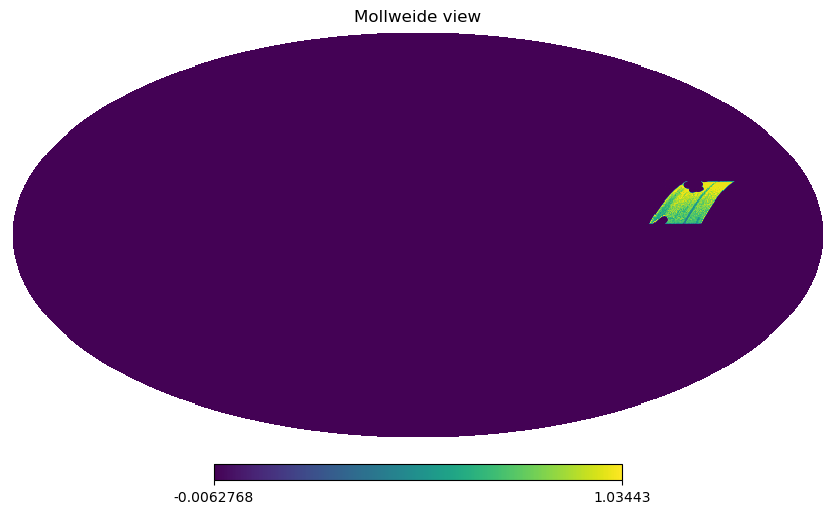

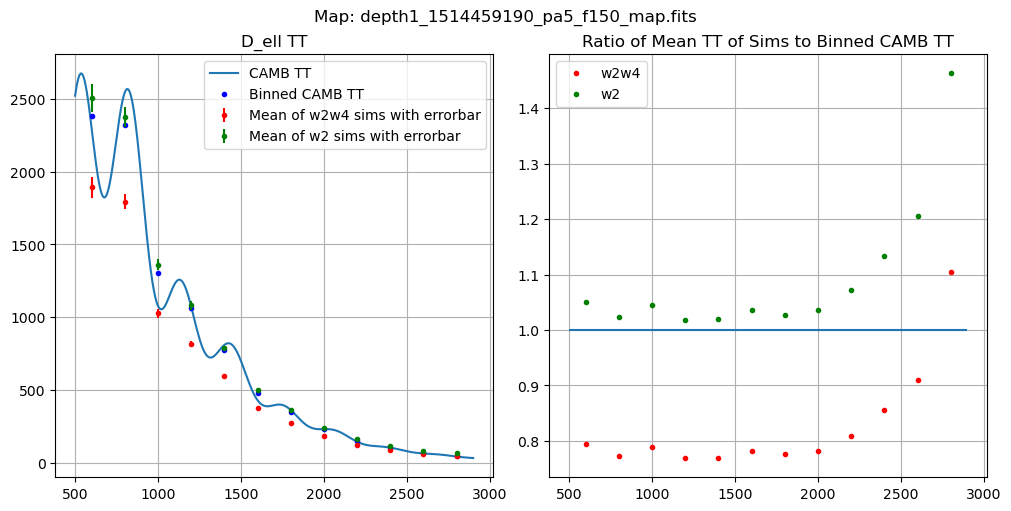

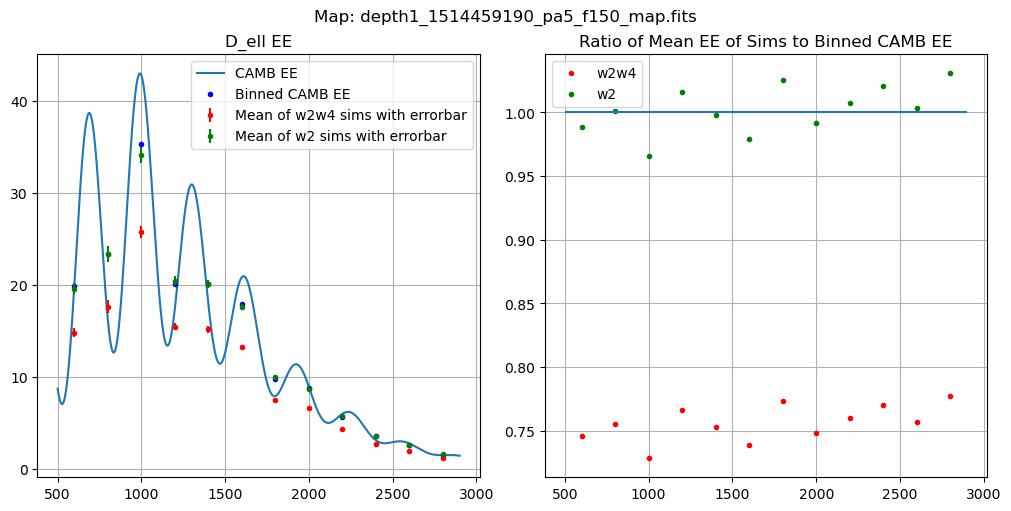

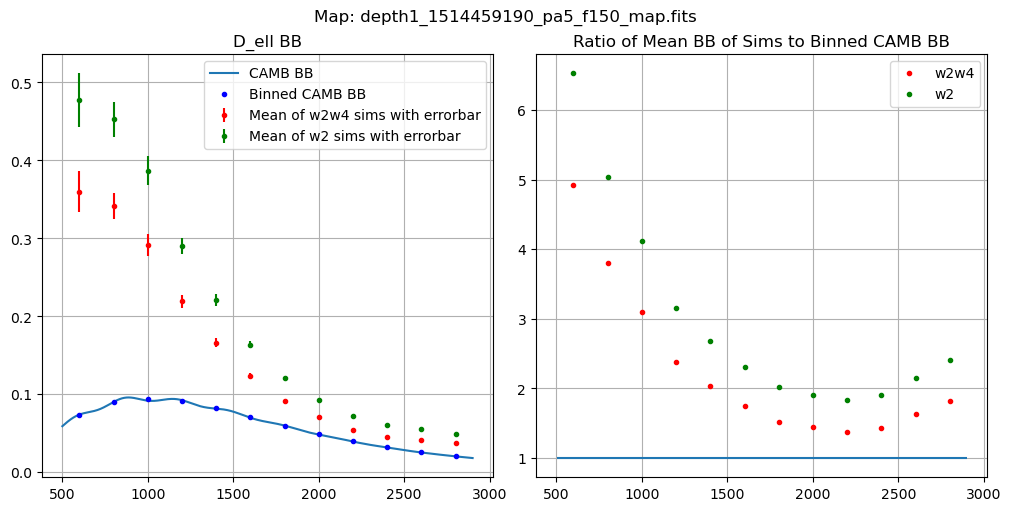

Map name: depth1_1515226705_pa5_f150_map.fits
Maps shape:  (3276, 7892)  Maps WCS:  car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[21417.00,583.00]}


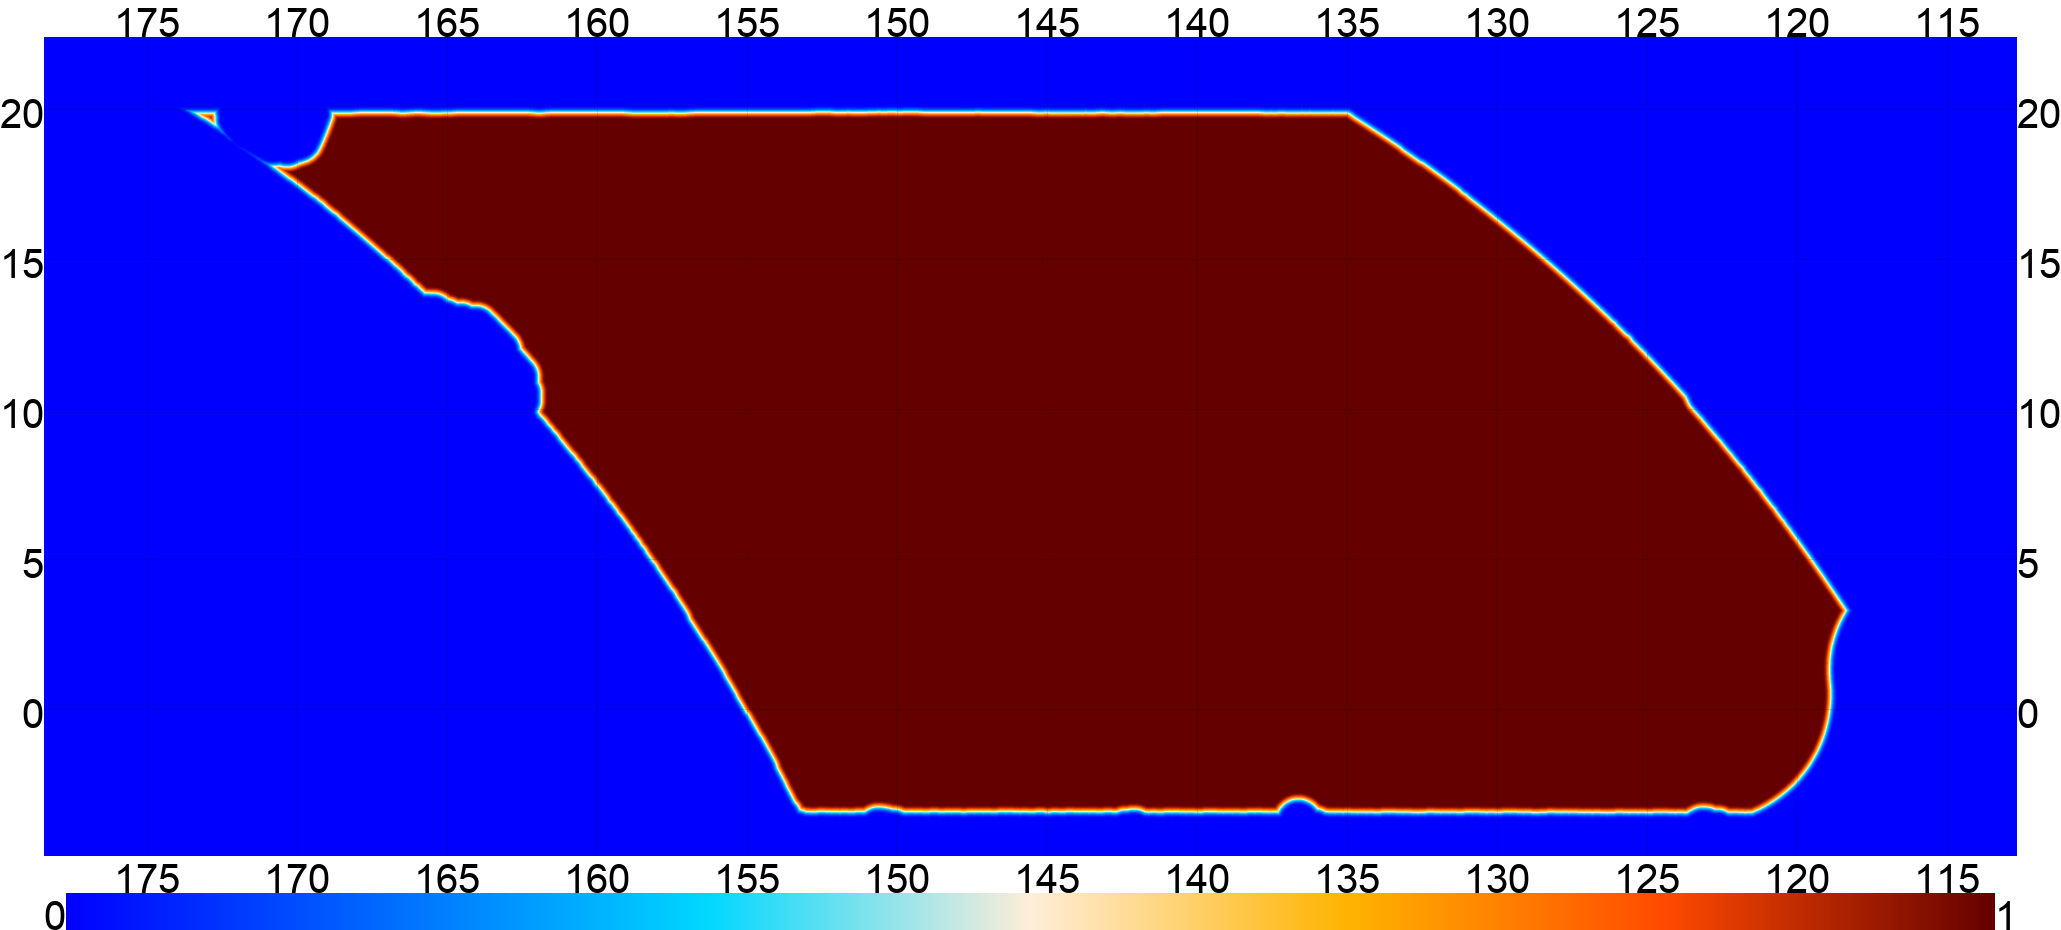

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [51:19<00:00, 61.58s/it]


Map name: depth1_1515226705_pa5_f150_map.fits
w2:  0.01284221431693349
w2w4:  0.018269862352585046
w2/w2w4:  0.7029179568567693
f_sky w/no w factor: 0.04260489942597247


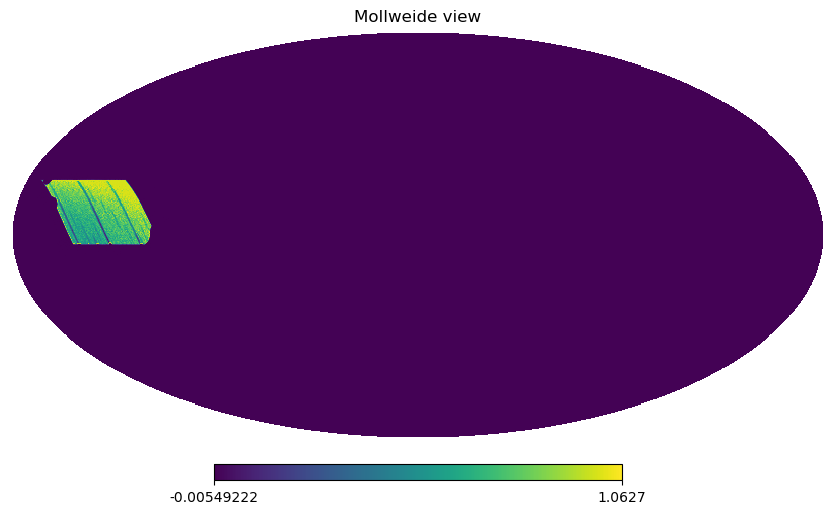

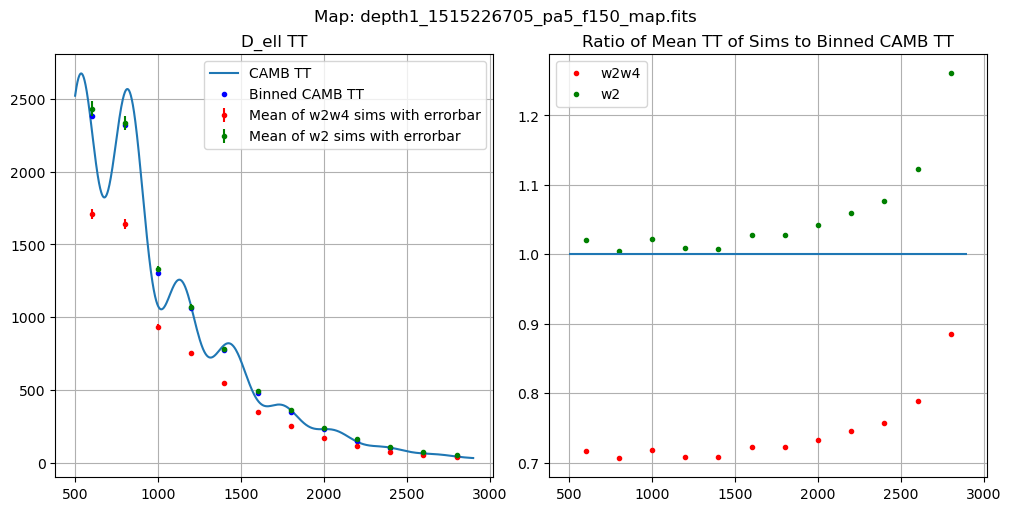

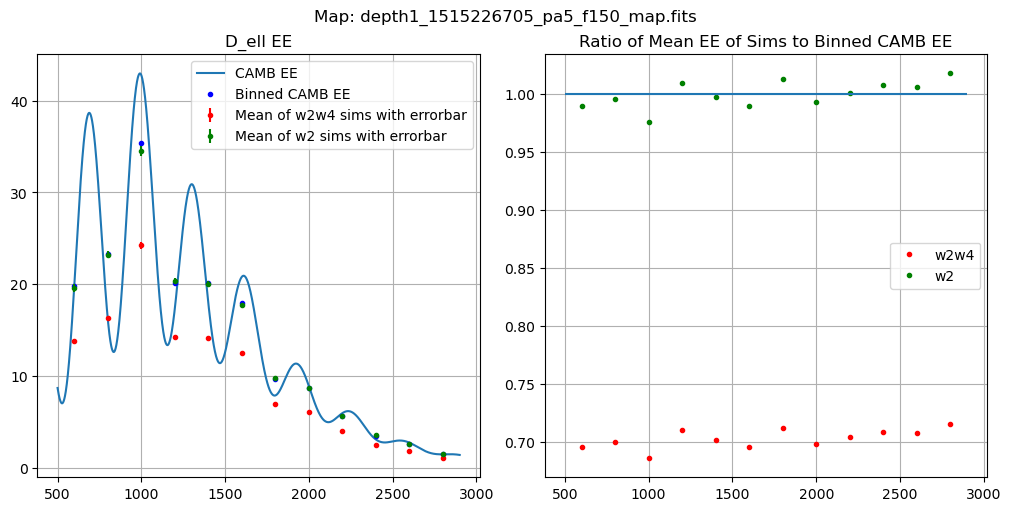

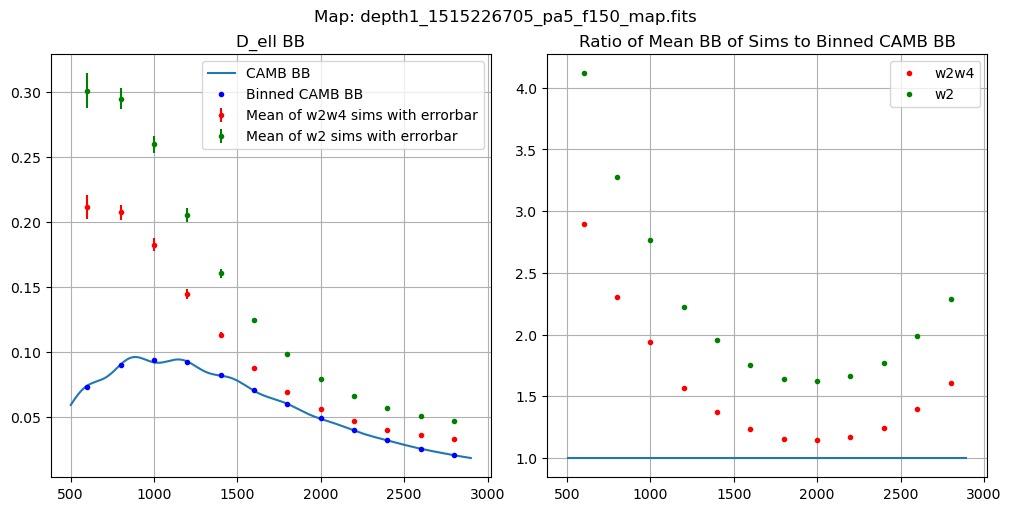

Map name: depth1_1617376861_pa5_f150_map.fits
Maps shape:  (5336, 10996)  Maps WCS:  car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[14431.00,7511.00]}


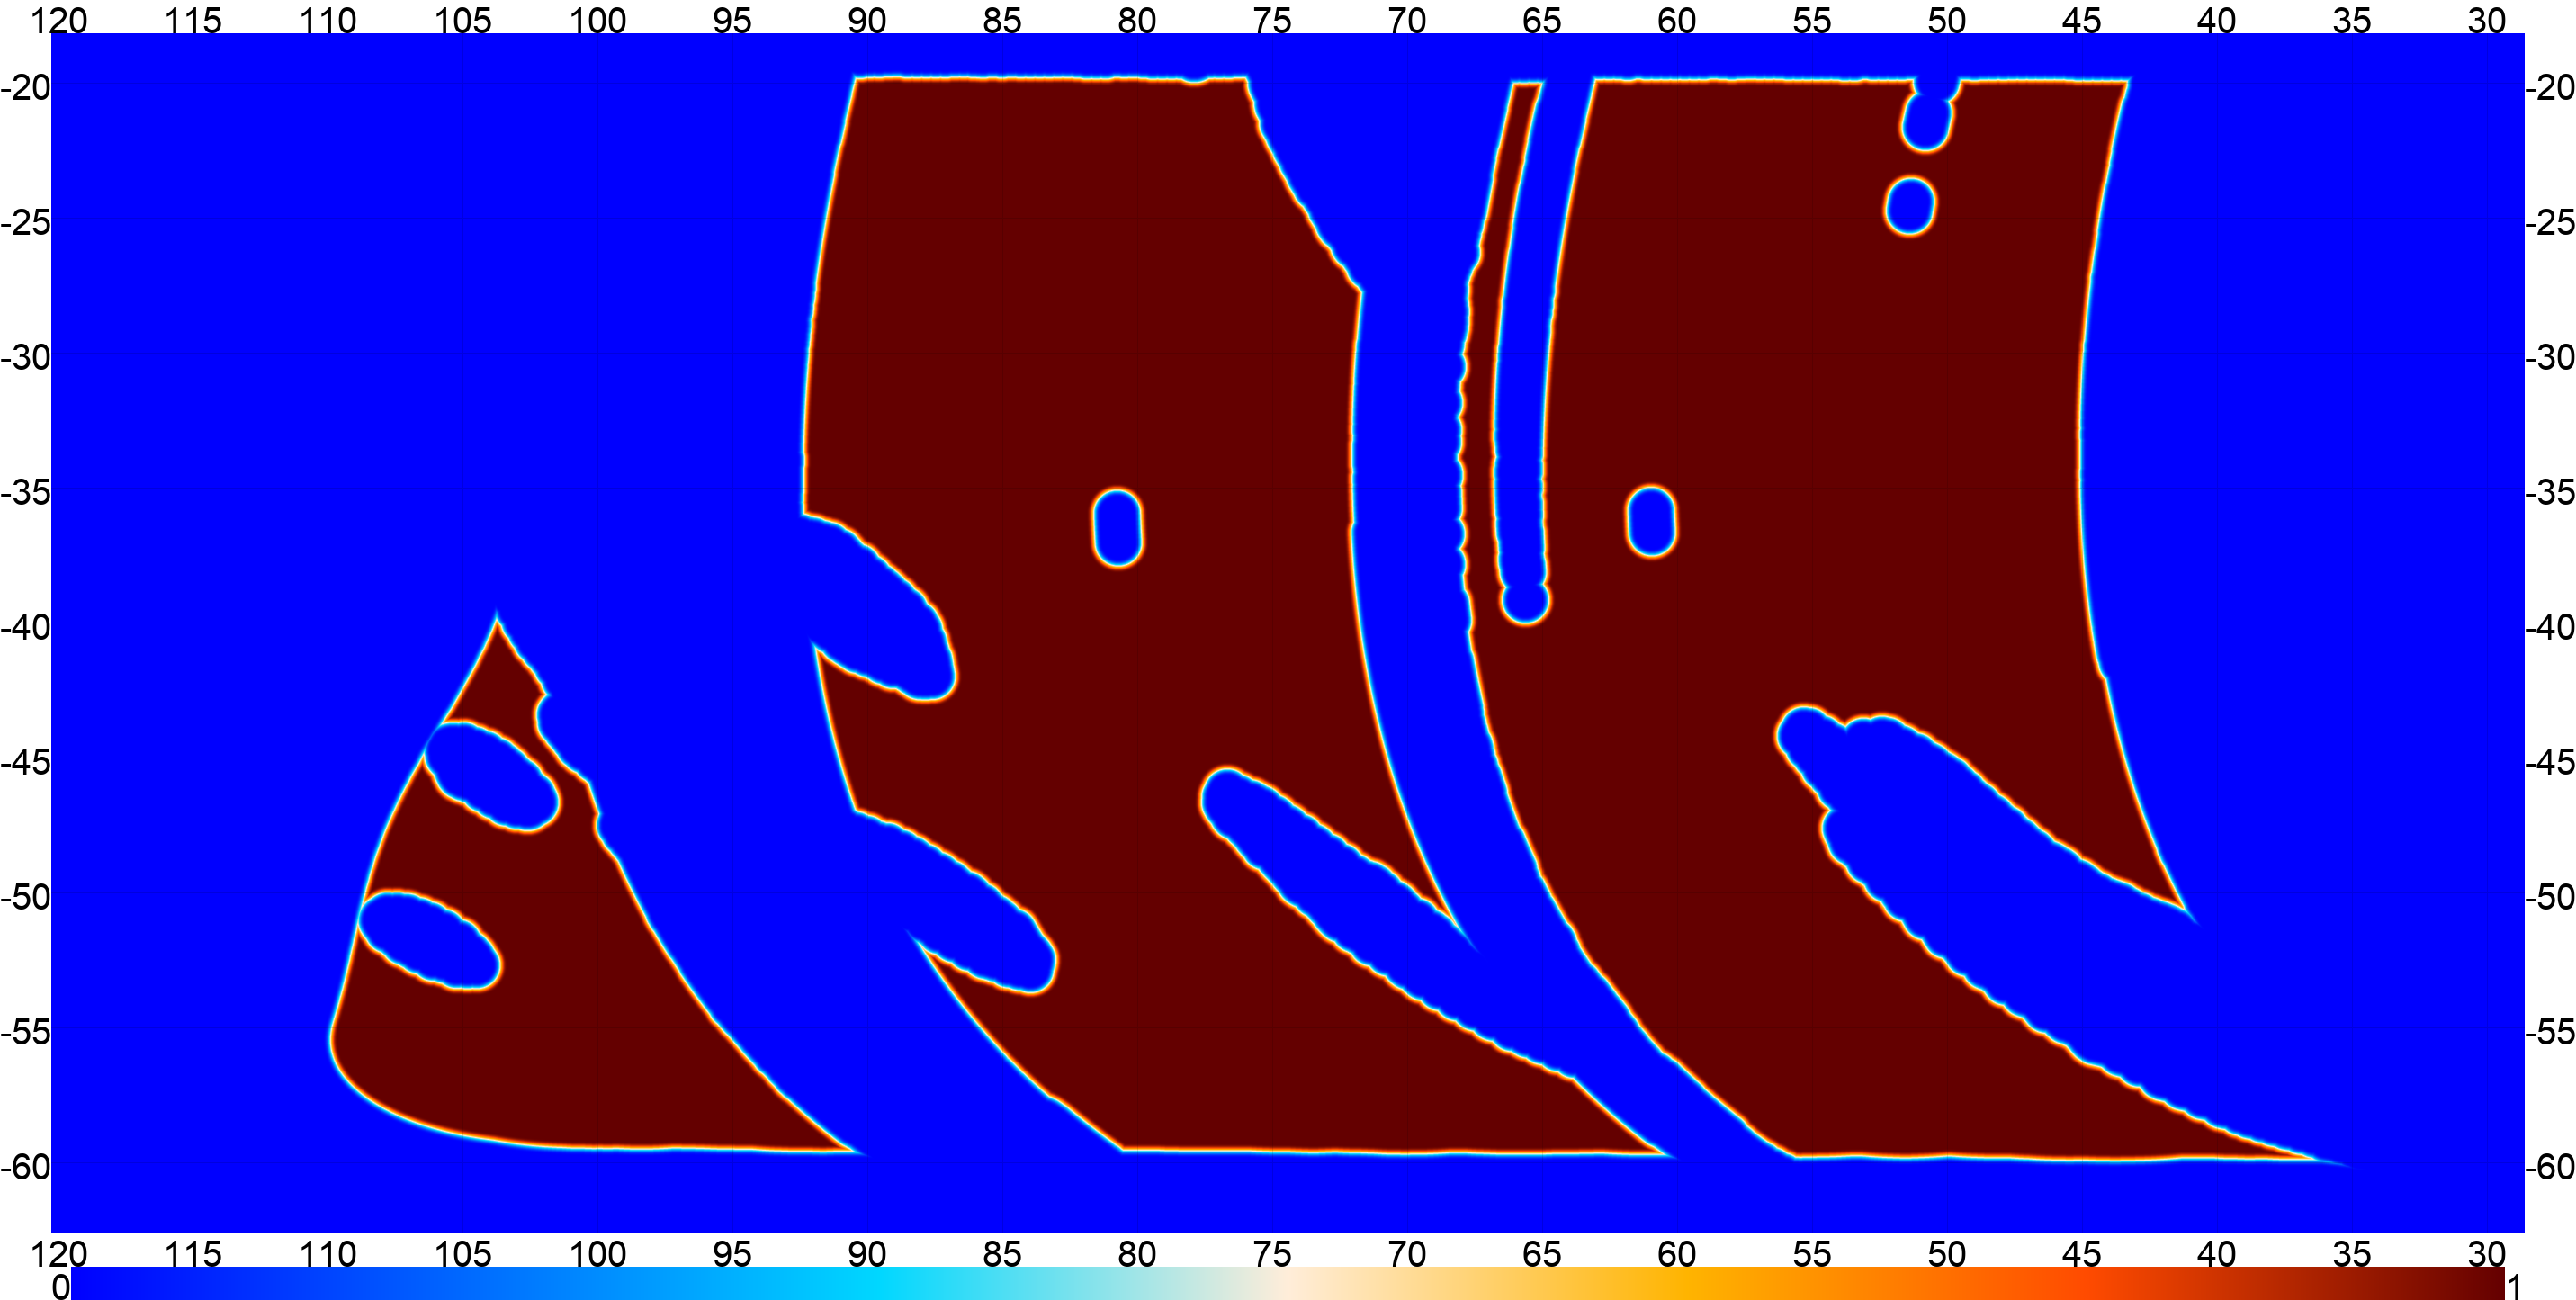

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [51:41<00:00, 62.03s/it]


Map name: depth1_1617376861_pa5_f150_map.fits
w2:  0.020440862610550902
w2w4:  0.0262631907999674
w2/w2w4:  0.778308422850748
f_sky w/no w factor: 0.07339485581250557


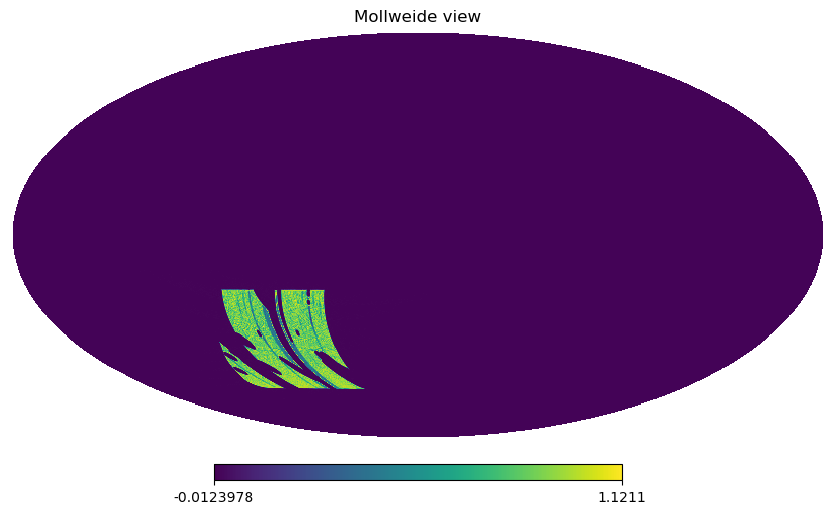

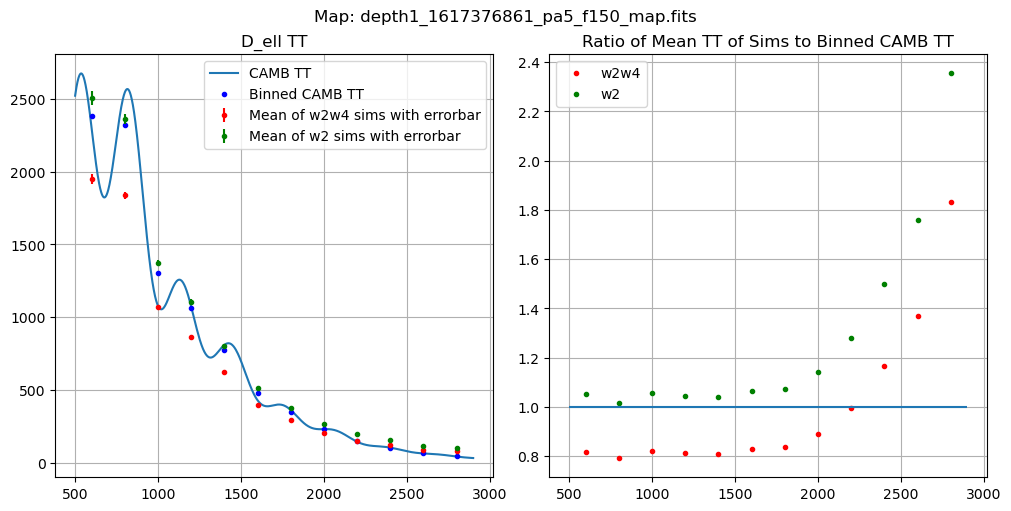

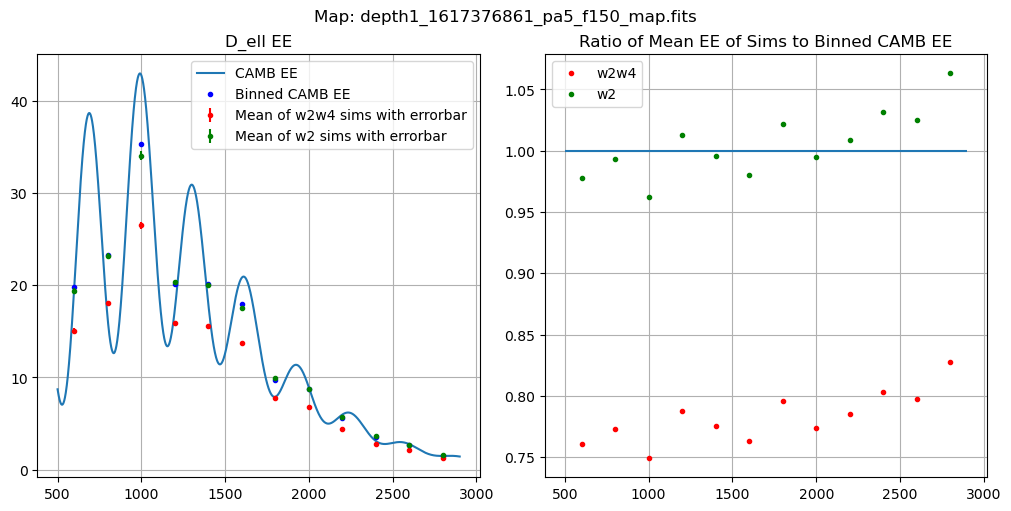

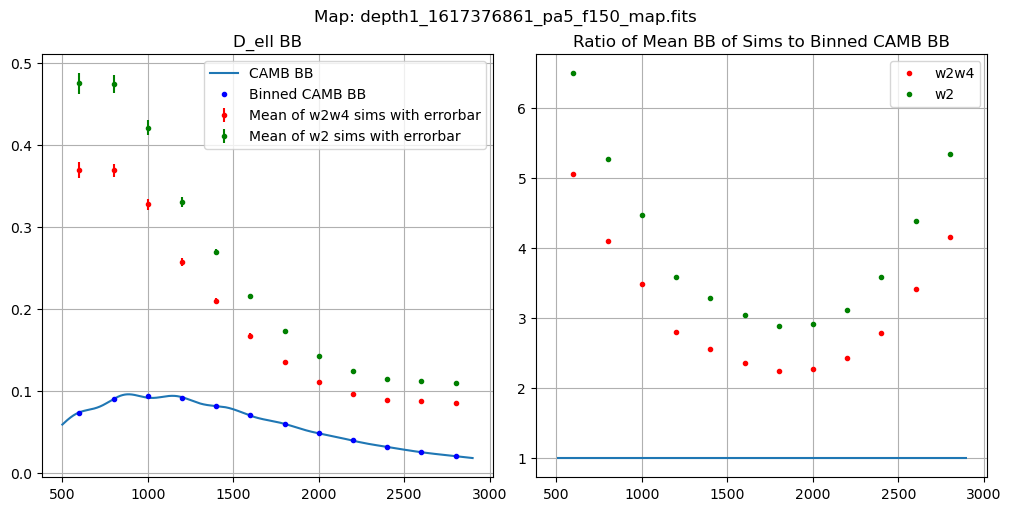

In [18]:
# For one of the depth-1 masks, generate healpix sims, ivar weight them with the depth-1 ivar, and 
# see what happens to the spectra
# Trying to be as similar to the real analysis as possible to avoid missing something, though the shift
# to healpix necessarily means some things are different

# Using a higher NSIDE so that we can still test the ell range we want
# Also should make the pixellization more similar
NSIDE = 2048

# ell range 500-2900, bin size of 200, 500 sims
N_sims = 50
lmin = 500
lmax = 2901
bin_size = 200
filter_radius = 0.5

bins = np.arange(lmin, lmax, bin_size)
centers = (bins[1:] + bins[:-1])/2.0

# binning CAMB input to match my spectra
digitized = np.digitize(ell[2:], bins, right=True)
CAMB_ClTT_binned = np.bincount(digitized, ClTT[2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
CAMB_ClEE_binned = np.bincount(digitized, ClEE[2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
CAMB_ClBB_binned = np.bincount(digitized, ClBB[2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]

# Loading galaxy mask
galaxy_mask_path = "/home/zbh5/act_analysis/dr6_analysis/act_mask_20220316_GAL070_rms_70.00_downgrade_None.fits"
galaxy_mask = enmap.read_map(galaxy_mask_path)

indices = [26,119,189,259] # which depth-1 maps to use - testing a single map first
for idx in indices:
    print("Map name: " + lines[idx])
    depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[idx]
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path)
    shape, wcs = depth1_maps[1].shape, depth1_maps[1].wcs
    print("Maps shape: ", shape, " Maps WCS: ", wcs)
    depth1_filtering_mask, depth1_indices = taper_mask_first_time(depth1_ivar, galaxy_mask, shape, wcs, 
                                                                  filter_radius)
    depth1_ivar_mask_tapered, depth1_ivar_indices = taper_mask_second_time(depth1_filtering_mask, 
                                                                           depth1_indices, filter_radius)
    # As a first step in healpix, I am only going to multiply by the second, ivar weighted, mask
    norm_ivar_T_mask, norm_ivar_QU_mask = normalize_ivar_mask(depth1_ivar, depth1_ivar_indices)
    
    # Converting masks to healpix - reapplying taper (as would have been done in apply_ivar_weighting)
    healpix_T_mask = reproject.map2healpix(norm_ivar_T_mask*depth1_ivar_mask_tapered,nside=NSIDE)
    healpix_QU_mask = reproject.map2healpix(norm_ivar_QU_mask*depth1_ivar_mask_tapered,nside=NSIDE)
    
    #eshow(depth1_maps[0], **keys_eshow)
    eshow(depth1_ivar_mask_tapered, **keys_eshow)
    #hp.mollview(healpix_T_mask)
    hp.mollview(healpix_QU_mask)
    
    spectra_TT = []
    spectra_EE = []
    spectra_BB = []
    
    for i in tqdm(range(N_sims)):
        alms = hp.sphtfunc.synalm((ClTT,ClTE,ClEE,ClBB))
        input_maps = hp.sphtfunc.alm2map(alms, nside=NSIDE, pol=True)
        #eshow(input_maps[1]*depth1_ivar_mask_tapered, **keys_eshow)

        w2 = np.mean(healpix_QU_mask**2)
        w2w4 = np.mean(healpix_QU_mask**2)**2 / np.mean(healpix_QU_mask**4)
        
        # Apply ivar weighting
        masked_maps = [input_maps[0]*healpix_T_mask, input_maps[1]*healpix_QU_mask, input_maps[2]*healpix_QU_mask]
        spectra = hp.sphtfunc.anafast(masked_maps,lmax=5400) / w2w4

        binned_TT = np.bincount(digitized, spectra[0][2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
        binned_EE = np.bincount(digitized, spectra[1][2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
        binned_BB = np.bincount(digitized, spectra[2][2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
        
        spectra_TT.append(binned_TT)
        spectra_EE.append(binned_EE)
        spectra_BB.append(binned_BB)
        
    spectra_TT = np.array(spectra_TT)
    spectra_EE = np.array(spectra_EE)
    spectra_BB = np.array(spectra_BB)
    variance_TT = np.var(spectra_TT,axis=0)
    mean_TT     = np.mean(spectra_TT, axis=0)
    variance_EE = np.var(spectra_EE,axis=0)
    mean_EE     = np.mean(spectra_EE, axis=0)
    variance_BB = np.var(spectra_BB,axis=0)
    mean_BB     = np.mean(spectra_BB, axis=0)
    
    #theory_var = 2*CAMB_ClTT_binned**2/(bincount*w2)
    #theory_var_w2w4 = 2*CAMB_ClTT_binned**2/(bincount*w2w4)
    
    f_sky = get_hivon_fsky_enmap(depth1_ivar_mask_tapered)
    
    w_ratio = w2/w2w4
    print("Map name: " + lines[idx])
    print("w2: ", w2)
    print("w2w4: ", w2w4)
    print("w2/w2w4: ", w_ratio)
    print("f_sky w/no w factor: " +str(f_sky))
    
    fig, axs = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))
    fig.suptitle("Map: " + lines[idx])
    axs[0].plot(ell[lmin:lmax],ell[lmin:lmax]*(ell[lmin:lmax]+1)*ClTT[lmin:lmax]/(2*np.pi),label='CAMB TT')
    axs[0].plot(centers,centers*(centers+1)*CAMB_ClTT_binned/(2*np.pi),'b.',label='Binned CAMB TT')
    axs[0].errorbar(centers,centers*(centers+1)*mean_TT/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance_TT)/(2*np.pi),fmt='r.',label='Mean of w2w4 sims with errorbar')
    axs[0].errorbar(centers,centers*(centers+1)*mean_TT/(2*np.pi*w_ratio),yerr=centers*(centers+1)*np.sqrt(variance_TT)/(2*np.pi*w_ratio),fmt='g.',label='Mean of w2 sims with errorbar')
    axs[0].set_title("D_ell TT")
    axs[0].legend()
    axs[0].grid()
    # Plotting the ratio of mean of sims to CAMB D_TT
    axs[1].plot(centers,mean_TT/CAMB_ClTT_binned,'r.', label='w2w4')
    axs[1].plot(centers,mean_TT/(w_ratio*CAMB_ClTT_binned),'g.', label='w2')
    axs[1].hlines(1.0,lmin+1,lmax-1)
    axs[1].set_title("Ratio of Mean TT of Sims to Binned CAMB TT")
    axs[1].legend()
    axs[1].grid()
    plt.show()
    plt.close()

    fig, axs = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))
    fig.suptitle("Map: " + lines[idx])
    axs[0].plot(ell[lmin:lmax],ell[lmin:lmax]*(ell[lmin:lmax]+1)*ClEE[lmin:lmax]/(2*np.pi),label='CAMB EE')
    axs[0].plot(centers,centers*(centers+1)*CAMB_ClEE_binned/(2*np.pi),'b.',label='Binned CAMB EE')
    axs[0].errorbar(centers,centers*(centers+1)*mean_EE/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance_EE)/(2*np.pi),fmt='r.',label='Mean of w2w4 sims with errorbar')
    axs[0].errorbar(centers,centers*(centers+1)*mean_EE/(2*np.pi*w_ratio),yerr=centers*(centers+1)*np.sqrt(variance_EE)/(2*np.pi*w_ratio),fmt='g.',label='Mean of w2 sims with errorbar')
    axs[0].set_title("D_ell EE")
    axs[0].legend()
    axs[0].grid()
    # Plotting the ratio of mean of sims to CAMB D_EE
    axs[1].plot(centers,mean_EE/CAMB_ClEE_binned,'r.', label='w2w4')
    axs[1].plot(centers,mean_EE/(w_ratio*CAMB_ClEE_binned),'g.', label='w2')
    axs[1].hlines(1.0,lmin+1,lmax-1)
    axs[1].set_title("Ratio of Mean EE of Sims to Binned CAMB EE")
    axs[1].legend()
    axs[1].grid()
    plt.show()
    plt.close()


    fig, axs = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))
    fig.suptitle("Map: " + lines[idx])
    axs[0].plot(ell[lmin:lmax],ell[lmin:lmax]*(ell[lmin:lmax]+1)*ClBB[lmin:lmax]/(2*np.pi),label='CAMB BB')
    axs[0].plot(centers,centers*(centers+1)*CAMB_ClBB_binned/(2*np.pi),'b.',label='Binned CAMB BB')
    axs[0].errorbar(centers,centers*(centers+1)*mean_BB/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance_BB)/(2*np.pi),fmt='r.',label='Mean of w2w4 sims with errorbar')
    axs[0].errorbar(centers,centers*(centers+1)*mean_BB/(2*np.pi*w_ratio),yerr=centers*(centers+1)*np.sqrt(variance_BB)/(2*np.pi*w_ratio),fmt='g.',label='Mean of w2 sims with errorbar')
    axs[0].set_title("D_ell BB")
    axs[0].legend()
    axs[0].grid()
    # Plotting the ratio of mean of sims to CAMB D_BB
    axs[1].plot(centers,mean_BB/CAMB_ClBB_binned,'r.', label='w2w4')
    axs[1].plot(centers,mean_BB/(w_ratio*CAMB_ClBB_binned),'g.', label='w2')
    axs[1].hlines(1.0,lmin+1,lmax-1)
    axs[1].set_title("Ratio of Mean BB of Sims to Binned CAMB BB")
    axs[1].legend()
    axs[1].grid()
    plt.show()
    plt.close()

In [15]:
print(digitized.shape)
print(spectra[0].shape)

(5399,)
(5401,)


In [20]:
# Making sure that the alms are different each time
alms1 = hp.sphtfunc.synalm((ClTT,ClTE,ClEE,ClBB))
alms2 = hp.sphtfunc.synalm((ClTT,ClTE,ClEE,ClBB))
print(alms1[0][0:10])
print(alms2[0][0:10])

[  0.        +0.j   0.        +0.j -37.52956617+0.j  -9.889004  +0.j
  -5.53393624+0.j  21.71802785+0.j  18.12942944+0.j  -9.99346155+0.j
   2.04992985+0.j   1.7344656 +0.j]
[  0.        +0.j   0.        +0.j  16.81865451+0.j -24.66467923+0.j
   4.90182191+0.j   8.66284483+0.j  16.04412879+0.j  -7.80358984+0.j
  -7.85211702+0.j   2.05183016+0.j]


In [21]:
# Saving one of the ivar weighted masks for Steve to play with
#hp.fitsfunc.write_map("example_ivar_weighted_healpix_mask.fits",healpix_QU_mask)

setting the output map dtype to [dtype('float64')]


In [23]:
print(np.array_equal(healpix_T_mask, healpix_QU_mask))
print(np.all(healpix_T_mask==healpix_QU_mask))

True
True


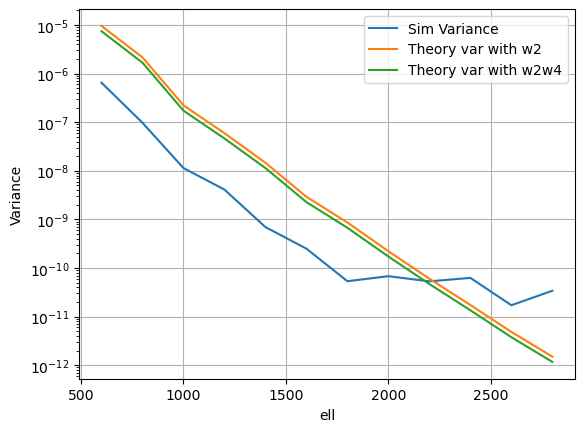

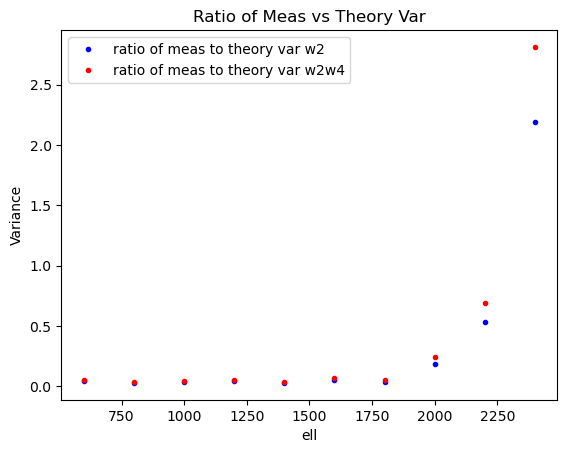

In [26]:
# Comparing to theoretical variance
bincount = (2*centers+1)*bin_size*f_sky
theory_var = 2*CAMB_ClTT_binned**2/(bincount*w2)
theory_var_w2w4 = 2*CAMB_ClTT_binned**2/(bincount*w2w4)

plt.semilogy(centers,variance_TT,label='Sim Variance')
plt.semilogy(centers,theory_var,label='Theory var with w2')
plt.semilogy(centers,theory_var_w2w4,label='Theory var with w2w4')
plt.legend()
plt.grid()
plt.xlabel("ell")
plt.ylabel("Variance")
plt.show()
plt.close()

plt.plot(centers[:-2],variance_TT[:-2]/theory_var[:-2],'b.',label='ratio of meas to theory var w2')
plt.plot(centers[:-2],variance_TT[:-2]/theory_var_w2w4[:-2],'r.',label='ratio of meas to theory var w2w4')
plt.legend()
plt.title("Ratio of Meas vs Theory Var")
plt.ylabel("Variance")
plt.xlabel("ell")
plt.show()
plt.close()